## Import Packages

```ModuleNotFoundError: No module named 'tensorflow.contrib'``` 오류가 발생하는 경우 tensorflow 2.0 이상 버전이 설치되어 있기때문입니다.
tensorflow.contrib는 tensorflow 2.0 이상 버전에서는 삭제되었습니다. 문제를 해결하기 위해서는 tensorflow 2.0 이상 벚은 삭제하고 tensorflow 1.13.1 이상 버전으로 재설치가 필요합니다.

```python
pip uninstall tensorflow
```
```python
pip install tensorflow==1.15.5
```

In [1]:
import tensorflow as tf # tensorflow 1.13.1+
import time
import cv2
import dlib
import face_recognition 
import numpy as np
import imutils
from imutils import face_utils
import argparse
from utils import plt_imshow

from UGATIT import UGATIT

tf.logging.set_verbosity(tf.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Argument definition

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--phase', type=str, default='test', help='[train / test]')
parser.add_argument('--light', type=bool, default=False, help='[U-GAT-IT full version / U-GAT-IT light version]')
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint', help='Directory name to save the checkpoints')
parser.add_argument('--result_dir', type=str, default='results', help='Directory name to save the generated images')
parser.add_argument('--log_dir', type=str, default='logs', help='Directory name to save training logs')
parser.add_argument('--sample_dir', type=str, default='samples', help='Directory name to save the samples on training')
parser.add_argument('--dataset', type=str, default='selfie2anime', help='dataset_name')
parser.add_argument('--augment_flag', type=bool, default=True, help='Image augmentation use or not')
parser.add_argument('--epoch', type=int, default=100, help='The number of epochs to run')
parser.add_argument('--iteration', type=int, default=10000, help='The number of training iterations')
parser.add_argument('--decay_flag', type=bool, default=True, help='The decay_flag')
parser.add_argument('--decay_epoch', type=int, default=50, help='decay epoch')

parser.add_argument('--gan_type', type=str, default='lsgan', help='[gan / lsgan / wgan-gp / wgan-lp / dragan / hinge]')
parser.add_argument('--batch_size', type=int, default=1, help='The size of batch size')
parser.add_argument('--print_freq', type=int, default=1000, help='The number of image_print_freq')
parser.add_argument('--save_freq', type=int, default=1000, help='The number of ckpt_save_freq')

parser.add_argument('--lr', type=float, default=0.0001, help='The learning rate')
parser.add_argument('--ch', type=int, default=64, help='base channel number per layer')

""" Weight """
parser.add_argument('--adv_weight', type=int, default=1, help='Weight about GAN')
parser.add_argument('--cycle_weight', type=int, default=10, help='Weight about Cycle')
parser.add_argument('--identity_weight', type=int, default=10, help='Weight about Identity')
parser.add_argument('--cam_weight', type=int, default=1000, help='Weight about CAM')
parser.add_argument('--GP_ld', type=int, default=10, help='The gradient penalty lambda')
parser.add_argument('--smoothing', type=bool, default=True, help='AdaLIN smoothing effect')

""" Generator """
parser.add_argument('--n_res', type=int, default=4, help='The number of resblock')

""" Discriminator """
parser.add_argument('--n_dis', type=int, default=6, help='The number of discriminator layer')
parser.add_argument('--n_critic', type=int, default=1, help='The number of critic')
parser.add_argument('--sn', type=bool, default=True, help='using spectral norm')

parser.add_argument('--img_size', type=int, default=256, help='The size of image')
parser.add_argument('--img_ch', type=int, default=3, help='The size of image channel')
    
args = parser.parse_args(args=[])

## Load Model

```ValueError: Variable generator_B/conv/conv2d/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:``` 오류 발생 시 이미 커널이 실행되고 있기 때문에 에러가 발생한 것입니다.

```python
tf.reset_default_graph()
```수행하고 다시 아래 코드를 수행하시면 됩니다.

In [3]:
checkpoint_path = 'checkpoint/UGATIT_selfie2anime_lsgan_4resblock_6dis_1_1_10_10_1000_sn_smoothing/UGATIT.model-1000000'

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

gan = UGATIT(sess, args)

tstamp = time.time()
print('\n[Model] loading...')

gan.build_model()

saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)
print('[Model] finished loading (%.4f sec)' % (time.time() - tstamp))


##### Information #####
# light :  False
# gan type :  lsgan
# dataset :  selfie2anime
# max dataset number :  0
# batch_size :  1
# epoch :  100
# iteration per epoch :  10000
# smoothing :  True

##### Generator #####
# residual blocks :  4

##### Discriminator #####
# discriminator layer :  6
# the number of critic :  1
# spectral normalization :  True

##### Weight #####
# adv_weight :  1
# cycle_weight :  10
# identity_weight :  10
# cam_weight :  1000

[Model] loading...
[Model] finished loading (3.2585 sec)


## Declare a face detector

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = face_recognition.api.pose_predictor_68_point

## Load Image

In [24]:
image_path = 'assets/images/Boris_Johnson.jpg'

org_image = cv2.imread(image_path)
# org_image = imutils.resize(org_image, width=2000) 
image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
# image = org_image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
rects = detector(gray, 1)

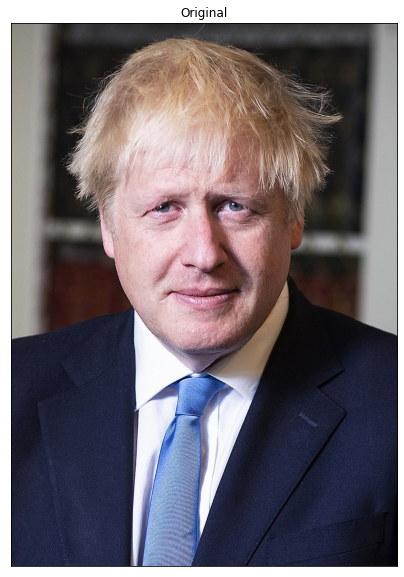

In [25]:
plt_imshow(["Original"], [org_image], figsize=(16,10))

## Face detection & Selfie2Anime 

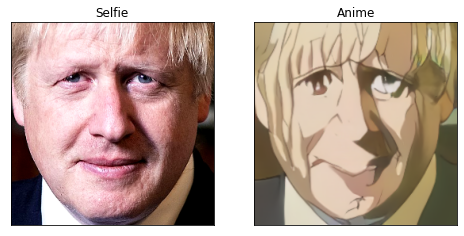

In [26]:
for (i, rect) in enumerate(rects):
    # 얼굴 영역의 얼굴 랜드마크를 결정한 다음 
    # 얼굴 랜드마크(x, y) 좌표를 NumPy Array로 변환합니다.
    
    # preprocessing
    shape = predictor(gray, rect)
    face_img = dlib.get_face_chip(image, shape, size=256, padding=0.2)
    
    brightness = 0
    contrast = 30
    face_img = np.int16(face_img)
    face_img = face_img * (contrast / 127 + 1) - contrast + brightness
    face_img = np.clip(face_img, 0, 255)
    face_img = np.uint8(face_img)
    
    img_input = cv2.resize(face_img, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    img_input = np.expand_dims(img_input, axis=0)
    img_input = img_input / 127.5 - 1

    # inference
    img_output = sess.run(gan.test_fake_B, feed_dict={gan.test_domain_A: img_input})

    # postprocessing
    img_output = (img_output + 1) * 127.5
    img_output = img_output.astype(np.uint8).squeeze()
    
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)

    plt_imshow(["Selfie", "Anime"], [face_img, img_output])